In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.stats import entropy

Sampling frequency from config: 200 Hz
Using file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0031/interictal_eeg_bipolar_clean_0.pkl
metadata_df shape: (81, 6)
data_df shape before transpose: (12000, 81)
Transposed data_df shape (each row = one electrode): (81, 12000)
metadata_df with 'data' column shape: (81, 7)
Electrode 0 signal shape: (12000,)
Selected 5-second segment length: 1000 samples
Filtered segment min: -49.05935405412024
Filtered segment max: 61.76374046825961
Filtered segment mean: -0.7598356163592804
Histogram computed successfully: hist shape = (26,), bin_edges shape = (27,)


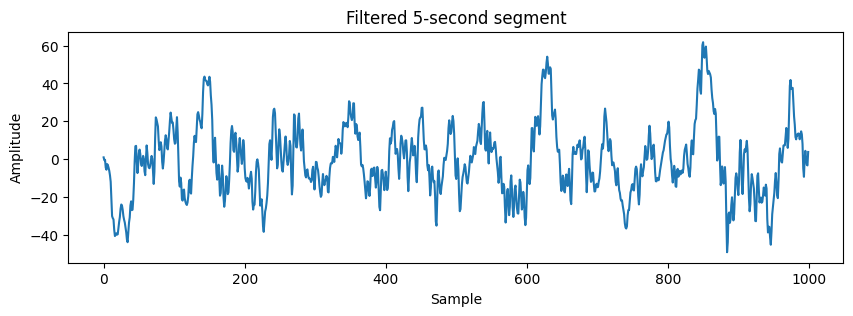


Summary:
Sampling frequency: 200 Hz
Each electrode should have 12000 samples (1 minute of data).
Data after transpose: (81, 12000) (rows = electrodes, columns = time samples)
Electrode 0 has signal shape: (12000,)


In [2]:
# --- Config ---
config = {
    'preprocessing': {
        'sampling_frequency': 200  # sampling rate in Hz (200 samples per second)
    },
    'features': {
        'spectral': {
            'bands': {
                'delta': [0.5, 4],
                'theta': [4, 8],
                'alpha': [8, 12],
                'beta': [12, 30],
                'gamma': [30, 80]
            }
        }
    }
}
fs = config['preprocessing']['sampling_frequency']
print(f"Sampling frequency from config: {fs} Hz")

# --- Choose a subject/epoch to debug ---
base_path = "/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean"
subject = "sub-RID0031"
epoch_idx = 1
# our naming pattern: interictal_eeg_bipolar_clean_{epoch_idx-1}.pkl
epoch_file = f"interictal_eeg_bipolar_clean_{epoch_idx-1}.pkl"
file_path = os.path.join(base_path, subject, epoch_file)
print("Using file:", file_path)

# --- Load the epoch ---
obj = pd.read_pickle(file_path)
if not isinstance(obj, dict) or 'metadata' not in obj or 'data' not in obj:
    raise ValueError("File does not contain the expected keys: 'metadata' and 'data'")

metadata_df = obj['metadata'].copy()
data_df = obj['data'].copy()  # expected shape: (time, electrodes) i.e. (12000, N)

print("metadata_df shape:", metadata_df.shape)
print("data_df shape before transpose:", data_df.shape)

# If data_df is (time, electrodes), we want to transpose so that each row is one electrode.
if data_df.shape[0] > data_df.shape[1]:
    data_df = data_df.T
    print("Transposed data_df shape (each row = one electrode):", data_df.shape)

# Attach each electrode's signal as a 1D numpy array in the 'data' column.
metadata_df['data'] = data_df.apply(lambda row: row.values, axis=1)
print("metadata_df with 'data' column shape:", metadata_df.shape)

# --- Examine one electrode's signal ---
row_idx = 0  # choose the first electrode
signal = metadata_df.iloc[row_idx]['data']
print(f"Electrode {row_idx} signal shape: {signal.shape}")  # should be (12000,)

# --- Define a filtering function (same as in your pipeline) ---
def apply_filters(data: np.ndarray, fs: float) -> np.ndarray:
    # Low-pass filter at 80 Hz
    b, a = butter(3, 80/(fs/2), btype='low')
    data = filtfilt(b, a, data)
    # High-pass filter at 1 Hz
    b, a = butter(3, 1/(fs/2), btype='high')
    data = filtfilt(b, a, data)
    # Notch filter at 60 Hz (Q=30)
    b, a = iirnotch(60, 30, fs)
    data = filtfilt(b, a, data)
    return data

# --- Select a 5-second segment ---
window_size_sec = 5
window_samples = int(window_size_sec * fs)  # e.g., 5*200 = 1000 samples
segment = signal[:window_samples]
print(f"Selected 5-second segment length: {len(segment)} samples")

# --- Debug the filtering of the segment ---
filtered_segment = apply_filters(segment, fs)
print("Filtered segment min:", np.nanmin(filtered_segment))
print("Filtered segment max:", np.nanmax(filtered_segment))
print("Filtered segment mean:", np.nanmean(filtered_segment))

# Check if the filtered segment contains NaNs or Infs
if np.isnan(filtered_segment).any():
    print("DEBUG: Filtered segment contains NaNs.")
if np.isinf(filtered_segment).any():
    print("DEBUG: Filtered segment contains Infs.")

# --- Try computing a histogram ---
try:
    hist, bin_edges = np.histogram(filtered_segment, bins='auto', density=True)
    print(f"Histogram computed successfully: hist shape = {hist.shape}, bin_edges shape = {bin_edges.shape}")
except ValueError as e:
    print("Histogram computation failed with error:", e)
    
# --- Optional: Plot the filtered segment ---
plt.figure(figsize=(10, 3))
plt.plot(filtered_segment)
plt.title("Filtered 5-second segment")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

# --- Summary ---
print("\nSummary:")
print(f"Sampling frequency: {fs} Hz")
print(f"Each electrode should have 12000 samples (1 minute of data).")
print(f"Data after transpose: {data_df.shape} (rows = electrodes, columns = time samples)")
print(f"Electrode {row_idx} has signal shape: {signal.shape}")


In [1]:
# clean unwanted junk

import os

def cleanup_feature_files(base_path, prefix="metadata_and_features_epch"):
    """
    Scans through each subject folder under base_path and removes files
    whose names start with the given prefix.
    """
    subject_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    for subject in subject_dirs:
        subject_path = os.path.join(base_path, subject)
        for fname in os.listdir(subject_path):
            if fname.startswith(prefix) and fname.endswith('.pkl'):
                file_to_remove = os.path.join(subject_path, fname)
                os.remove(file_to_remove)
                print(f"Removed file: {file_to_remove}")

if __name__ == '__main__':
    base_path = "/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean"
    cleanup_feature_files(base_path)

Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch9.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch11.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch10.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch8.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch12.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch13.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivati

In [2]:
import os

def cleanup_feature_files(base_path, prefix="metadata_and_features_epch"):
    subject_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    for subject in subject_dirs:
        subject_path = os.path.join(base_path, subject)
        for fname in os.listdir(subject_path):
            if fname.startswith(prefix) and fname.endswith('.pkl'):
                file_to_remove = os.path.join(subject_path, fname)
                os.remove(file_to_remove)
                print(f"Removed file: {file_to_remove}")

if __name__ == '__main__':
    base_path = "/Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean"
    cleanup_feature_files(base_path)

Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch9.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch11.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch10.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch8.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch12.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivatives/clean/sub-RID0064/metadata_and_features_epch13.pkl
Removed file: /Users/tereza/nishant/atlas/atlas_work_terez/atlas_harmonization/Data/hup/derivati